## Dependencies

In [1]:
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average, Add, Reshape, GlobalAveragePooling1D, LSTM, Conv1D, SpatialDropout1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    # Map misspellings
#     train[feature] = train[feature].apply(lambda x: map_misspellings(x))
#     validation[feature] = validation[feature].apply(lambda x: map_misspellings(x))
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())

## Train/validation sets

In [5]:
# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']


X_train = [X_train_title, X_train_body, X_train_answer]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']

X_valid = [X_valid_title, X_valid_body, X_valid_answer]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [6]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.3

# Model

In [7]:
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def encoder_block(input_layer):
    encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    
    return encoder

In [8]:
# Title
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
encoded_title = encoder_block(input_title)

title = Reshape((EMBEDDDING_SIZE, 1))(encoded_title)
title = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(title)
title_out = GlobalAveragePooling1D()(title)

# Body
input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
encoded_body = encoder_block(input_body)

body = Reshape((EMBEDDDING_SIZE, 1))(encoded_body)
body = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(body)
body_out = GlobalAveragePooling1D()(body)

# Answer
input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
encoded_answer = encoder_block(input_answer)

answer = Reshape((EMBEDDDING_SIZE, 1))(encoded_answer)
answer = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(answer)
answer_out = GlobalAveragePooling1D()(answer)


# Output
x = Concatenate()([encoded_title, encoded_body, encoded_answer, title_out, encoded_body, answer_out])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='lecun_normal', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_title[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_answer[0][0]               
______________________________________________________________________________________________

# Train model

In [9]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-7, verbose=1)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
callback_list = [rlrop, spearmanCallback]

optimizer = optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/50
spearman-rho: 0.2636 val_spearman-rho: 0.2491
4863/4863 - 267s - loss: 0.4677 - val_loss: 0.4083
Epoch 2/50
spearman-rho: 0.3149 val_spearman-rho: 0.2961
4863/4863 - 250s - loss: 0.4049 - val_loss: 0.3969
Epoch 3/50
spearman-rho: 0.3445 val_spearman-rho: 0.3191
4863/4863 - 249s - loss: 0.3942 - val_loss: 0.3906
Epoch 4/50
spearman-rho: 0.3638 val_spearman-rho: 0.3321
4863/4863 - 246s - loss: 0.3883 - val_loss: 0.3866
Epoch 5/50
spearman-rho: 0.3780 val_spearman-rho: 0.3391
4863/4863 - 246s - loss: 0.3839 - val_loss: 0.3847
Epoch 6/50
spearman-rho: 0.3878 val_spearman-rho: 0.3442
4863/4863 - 248s - loss: 0.3811 - val_loss: 0.3821
Epoch 7/50
spearman-rho: 0.3966 val_spearman-rho: 0.3482
4863/4863 - 249s - loss: 0.3787 - val_loss: 0.3808
Epoch 8/50
spearman-rho: 0.4042 val_spearman-rho: 0.3516
4863/4863 - 249s - loss: 0.3768 - val_loss: 0.3798
Epoch 9/50
spearman-rho: 0.4103 val_spearman-rho: 0.3535
4863/4863 - 248s - loss: 0.3755

## Model loss graph

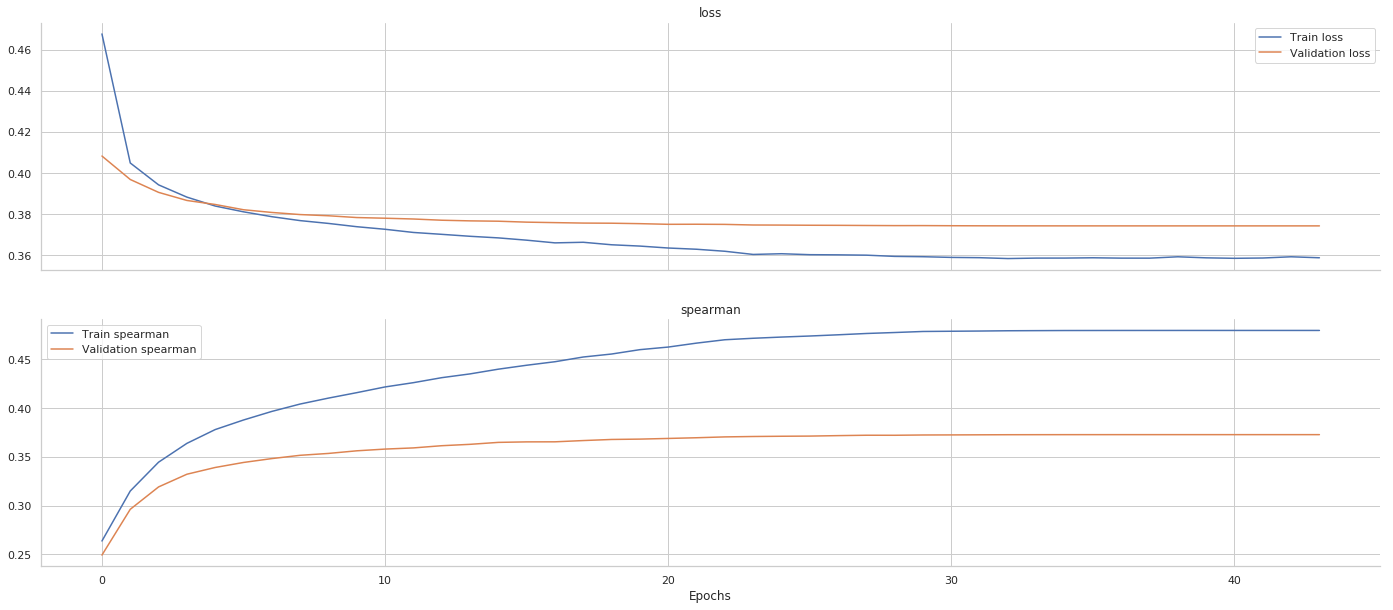

In [10]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [11]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))
# 0.492	0.374

,Label,Train,Validation
0,Averaged,0.480,0.373
1,question_asker_intent_understanding,0.456,0.403
2,question_body_critical,0.707,0.623
3,question_conversational,0.456,0.407
4,question_expect_short_answer,0.480,0.266
5,question_fact_seeking,0.502,0.340
6,question_has_commonly_accepted_answer,0.542,0.429
7,question_interestingness_others,0.446,0.397
8,question_interestingness_self,0.590,0.533
9,question_multi_intent,0.574,0.441


## By category

In [12]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.445,0.334,0.49,0.369,0.375,0.2,0.509,0.412,0.504,0.38


#### Save model weights and ecoders

In [13]:
model.save_weights(model_path)